In [1]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 5.3 MB/s 


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import pandas as  pd

import random
import os

import pickle5 as pickle
import pandas as pd
import math


In [3]:
class config:
    seed = 42

In [4]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [5]:
seed_everything(config.seed)

In [6]:
batch_size = 1

In [7]:
def augment(x,y,size,half_size,data_count,flip_yn,rotation_degree,affine_rate):
    
    
    if flip_yn == 1:
        x_return = x[:, :, :, ::-1]
    else :
        x_return = x    
    if rotation_degree != 0:
        rotation = []
        #회전 좌표 구하기
        for i in range(-half_size,half_size+1,1):
            for j in range(-half_size,half_size+1,1):
                if i*j !=0 :
                    #처음 좌표
                    coor_y = half_size-j
                    coor_x = i+half_size
                    if coor_y > half_size : coor_y = coor_y-1
                    if coor_x > half_size : coor_x = coor_x-1

                    #변경 좌표
                    coor_y_2 = half_size-(i*math.sin(math.pi * (rotation_degree / 180)) + j*math.cos(math.pi * (rotation_degree / 180)))
                    coor_x_2 = (i*math.cos(math.pi * (rotation_degree / 180)) - j*math.sin(math.pi * (rotation_degree / 180)))+half_size
                    if coor_y_2 > half_size : coor_y_2 = coor_y_2-1
                    if coor_x_2 > half_size : coor_x_2 = coor_x_2-1

                    rotation.append([coor_y,coor_x,coor_y_2,coor_x_2])
        data_rotation = pd.DataFrame(rotation)
        data_rotation = data_rotation[(data_rotation[2]>0) & (data_rotation[3]>0)&(data_rotation[2]<size) & (data_rotation[3]<size)]
        x_rotation = np.zeros((data_count,3,size,size))
        for i in range(size) :
            for j in range(size):
                data_rotation_2 = data_rotation[ ((round(data_rotation[2])==i)|(round(data_rotation[2],0)==i)) & ((round(data_rotation[3])==j)|(round(data_rotation[3],0)==j)) ]
                if len(data_rotation_2) > 0:
                    x_rotation[:,:,i,j] = np.mean(x_return[:,:,data_rotation_2[0],data_rotation_2[1]],axis=2)
        x_return = x_rotation

    if affine_rate != 0 :
        pixel = int(size*affine_rate)
        dummy = np.zeros((data_count,3,size,pixel))
        x_return = np.concatenate((dummy,x_return[:,:,:,:-pixel]),axis=3)
        dummy = np.zeros((data_count,3,pixel,size))
        x_return = np.concatenate((dummy,x_return[:,:,:-pixel,:]),axis=2)

    y_return = y
    return x_return,y_return

In [8]:
### transform 설정

transform_array = []
#transform_array.append(transform0)
for i in [0]: #[0,1]:
    for j in [2,3,4,6,7,8,9,10]: #[0,5,15]:
        for k in [0]: #[0,0.1,0.2,0.3,0.4]:
            transform1  = [i,j,k]  
            transform_array.append(transform1)



In [9]:
with open('/content/drive/MyDrive/imagenet/32/train_data', 'rb') as fo:
    d = pickle.load(fo)
x = d['data']
y = d['labels']  

x_train  =  torch.FloatTensor(x)  
y_train  =  torch.LongTensor(y)

trainset0 = torch.utils.data.TensorDataset(x_train, y_train)
trainloader0 = torch.utils.data.DataLoader(trainset0, batch_size=batch_size, shuffle=False)

trainset_array = []
trainloader_array = []


for i in range(len(transform_array)):
    
    x_augment, y_augment   =  augment(x,y,32,16,len(x),transform_array[i][0],transform_array[i][1],transform_array[i][2])

    x_augment  =  torch.FloatTensor(x_augment.copy())  
    y_augment  =  torch.LongTensor(y_augment)

        
    trainset1 = torch.utils.data.TensorDataset(x_augment, y_augment)
    trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size, shuffle=False)

    trainset_array.append(trainset1)
    trainloader_array.append(trainloader1)


In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [13]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
PATH = '/content/drive/MyDrive/Colab Notebooks/졸업논문/imagenet32_net.pth'

In [15]:
new_net = Net()
new_net.load_state_dict(torch.load(PATH))
new_net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
new_net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
list(new_net.children())[:-3]

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

In [18]:
new_net = torch.nn.Sequential(*(list(new_net.children())[:-3]))

In [19]:
new_net

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
)

In [20]:
for name, param in new_net.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print(param)
    print('=====')

name:  0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([6, 3, 5, 5])
param.requires_grad:  True
Parameter containing:
tensor([[[[ 4.2651e-01,  1.1433e+00,  1.2667e+00,  7.6275e-01,  2.0330e-01],
          [ 6.5731e-01,  1.5139e+00,  1.5791e+00,  1.2226e+00,  3.7087e-01],
          [ 5.9758e-01,  1.1912e+00,  1.1422e+00,  9.1653e-01,  4.2838e-01],
          [ 2.3586e-01,  6.4399e-01,  8.7709e-01,  3.8236e-01,  3.5866e-01],
          [-7.9829e-02,  1.2327e-01,  2.0447e-01,  1.2770e-01, -2.1891e-01]],

         [[-1.0730e-02, -2.5520e-01, -3.0020e-01, -2.2488e-01,  5.2235e-02],
          [-3.0059e-01, -6.1816e-01, -7.4617e-01, -5.7133e-01, -1.0113e-01],
          [-2.7906e-01, -6.2113e-01, -8.4859e-01, -6.1791e-01, -2.1603e-01],
          [-1.7978e-01, -5.1626e-01, -4.6848e-01, -5.1956e-01, -1.2186e-01],
          [-2.7397e-01, -1.9592e-01, -3.9554e-01, -3.9507e-01, -4.3562e-01]],

         [[-3.6316e-01, -7.0191e-01, -7.6179e-01, -4.1662e-01, -8.7056e-02],
      

In [21]:
dataiter = iter(trainloader0)
images, labels = dataiter.next()

In [22]:
print(labels.shape)
print(images.shape)

torch.Size([1])
torch.Size([1, 3, 32, 32])


In [23]:
new_net.eval()

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
)

In [24]:
with torch.no_grad():
    outputs = new_net(images.to(device))

In [25]:
outputs.shape

torch.Size([1, 16, 10, 10])

In [26]:
def get_cosine_similarity(x1, x2):
    return (x1 * x2).sum() / ((x1**2).sum()**.5 * (x2**2).sum()**.5)

In [27]:
def image_array_save(image_array,dataloader) :
    i = 0
    with torch.no_grad():
        for data in dataloader:
            if i == 500:
                break
            i=i+1    
            images, labels = data
            outputs = new_net(images.to(device))
            image_array.append(outputs)        

In [28]:
image_array = []

image_0 = [] 
image_array_save(image_0,trainloader0)


image_elements_array = []   
for i in range(len(transform_array)):
    image_elements_array = []    
    image_array_save(image_elements_array,trainloader_array[i])
    image_array.append(image_elements_array)

In [29]:
len(image_array)

8

In [30]:
def cosine_sim(image_1,image_2):
    ret_total = 0
    for i in range(500):
        ret = get_cosine_similarity(image_1[i], image_2[i])
        ret_total = ret_total+ret
    print(ret_total/500)   

In [ ]:
for i in range(len(transform_array)):
    print(i)
    cosine_sim(image_0,image_array[i])

0
tensor(0.9459, device='cuda:0')
1
tensor(0.5905, device='cuda:0')
2
tensor(0.2599, device='cuda:0')


In [ ]:
############################# PCA 적용해서 유사도 판별에 사용할 차원 줄여보기 #######################################
#### PCA를 통해 추출한 주성분으로 유사도 비교

In [31]:
from sklearn.decomposition import PCA

In [32]:
X = image_0
for i in range(len(X)) : #넘파이로 변환하기 위해 cpu로 변경
    X[i] = X[i].reshape(1600).cpu().numpy()

In [33]:
pca = PCA(n_components=20)
pca.fit_transform(X)

array([[ 160.48446553, -163.59458727,  -35.90422843, ...,    8.05882355,
          17.75210281,  -13.10788981],
       [   7.31801894,  -79.61238977, -357.38438013, ...,  -15.06045409,
         -40.80335004,  -18.52269535],
       [ 230.33269145, -223.01925123,  108.29179536, ...,   -4.93665946,
          24.83797624,  -32.46280953],
       ...,
       [  76.24261914,   64.12919413,  159.51892767, ...,   13.652652  ,
          36.23602795,  -14.89245412],
       [ -77.36194636, -115.66899929,  -17.04335043, ...,   61.99541246,
         -61.84522345,  -16.03067408],
       [ -77.52963892,   92.87245887,  159.27349668, ...,   18.51897545,
          34.81153813,    5.99253033]])

In [34]:
pd.Series(np.cumsum(pca.explained_variance_ratio_))
#80이 넘는 지점을 선택

0     0.257228
1     0.417841
2     0.499033
3     0.564891
4     0.620003
5     0.651697
6     0.679945
7     0.704976
8     0.726776
9     0.746926
10    0.764895
11    0.780190
12    0.794665
13    0.806899
14    0.818251
15    0.827662
16    0.836201
17    0.843637
18    0.850845
19    0.857315
dtype: float64

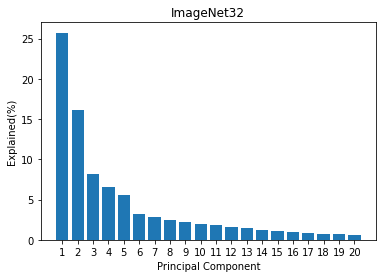

In [35]:
# PCA 결과의 각 성분의 설명력에 대한 그래프 그리기
# https://alex-blog.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D%EC%9D%84-%EC%9C%84%ED%95%9C-%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D3-PCA 블로그 참조
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'{i+1}')
    

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Explained(%)')
plt.xlabel('Principal Component')
plt.title('ImageNet32')
plt.show()

In [ ]:
pca = PCA(n_components=14)
x_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.25722803 0.16061284 0.08119214 0.0658577  0.05511216 0.03169429
 0.02824802 0.02503104 0.0218002  0.02014966 0.01796904 0.01529488
 0.01447528 0.0122336 ]
0.8068988642354452


In [ ]:
x_pca

array([[ 160.48446553, -163.59458727,  -35.90422841, ...,   76.41212719,
         -14.46505092,   11.56116834],
       [   7.31801894,  -79.61238977, -357.38438009, ...,   41.9860238 ,
          82.79630047,    4.97962159],
       [ 230.33269145, -223.01925123,  108.29179537, ...,  -67.99396852,
          -3.93823247,  -37.11937136],
       ...,
       [  76.24261914,   64.12919413,  159.51892767, ...,   -0.88990652,
          -3.99213361,    7.78363478],
       [ -77.36194636, -115.66899929,  -17.04335044, ...,  -70.84867273,
         -31.8037829 ,   59.52856898],
       [ -77.52963892,   92.87245887,  159.2734967 , ...,    8.36379117,
           4.8005413 ,   58.2289359 ]])

In [ ]:
for i in range(len(image_array)):
    X_1 = image_array[i]
    for j in range(len(X_1)) : #넘파이로 변환하기 위해 cpu로 변경
        image_array[i][j] = image_array[i][j].reshape(1600).cpu().numpy()
    print(i)
    cosine_sim(x_pca,pca.transform(image_array[i]))

0
0.9999656772795524
1
0.9987376737731433
2
0.9957600817853024
3
0.9859787709465466
4
0.974058422218099
5
0.962073699846481
6
0.9430496190986034
7
0.9181315516562499
